In [7]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime, timedelta

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate

In [8]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_rotation_imu_long_20"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_9.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


mocap df

In [9]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")

_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)), "sk40", f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

IMU

In [10]:
timeoffset = 0

In [11]:
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

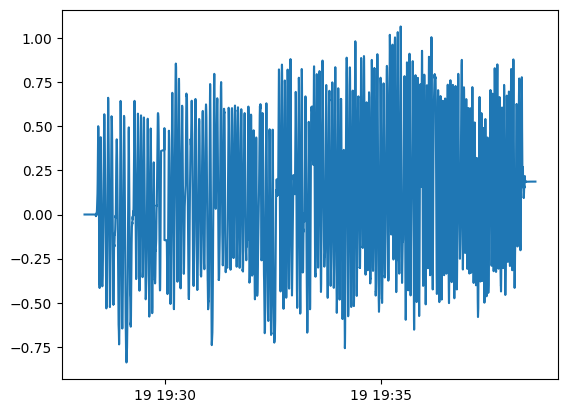

In [12]:
plt.plot(_imu_df["time"],np.deg2rad(_imu_df["ang_z"].to_numpy()))
# plt.plot(ar_df["time"],ar_df["z"].to_numpy())
# plt.xlim([ar_df["time"][50], ar_df["time"][-1]])

In [13]:
ar_df = pl.read_csv("ar_df.csv")

if type(ar_df["time"][0]) != datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [14]:
_om = get_rb_marker_name(1)
_xm = get_rb_marker_name(3)
_zm = get_rb_marker_name(4)

In [15]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [16]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [17]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

  0%|          | 0/61539 [00:00<?, ?it/s]

 52%|█████▏    | 31761/61539 [00:05<00:06, 4913.43it/s]

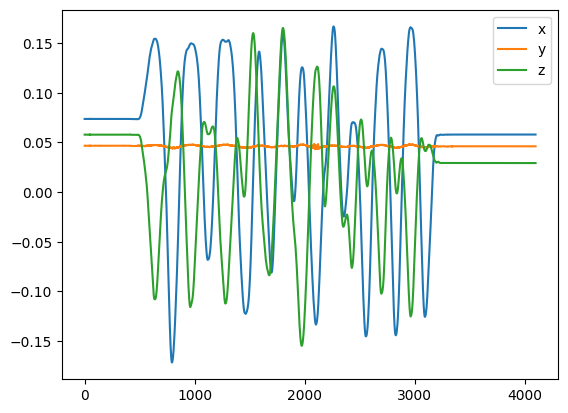

In [ ]:
plt.plot(_mocap_df[_om["x"]], label="x")
plt.plot(_mocap_df[_om["y"]], label="y")
plt.plot(_mocap_df[_om["z"]], label="z")
plt.legend()

In [ ]:
filter_size = 11
filter_order = 3

filter_0_df = ar_df.clone()
# apply savgol filter for columns rx, ry, rz

filter_0_df = filter_0_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                            ])

In [ ]:
rmat = []
for i in range(len(filter_0_df)):
    rotation_vectors_0 = filter_0_df[["rx", "ry", "rz"]][i].to_numpy()
    rotation_matrix_0 = cv2.Rodrigues(rotation_vectors_0)[0]
    rmat.append(rotation_matrix_0)

Orthonormalizing rmat

In [ ]:
# orthonormalizing rmat
orthormat = np.linalg.qr(rmat)[0]

In [ ]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

Bringing to skateboard frame

In [ ]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 4097/4097 [00:00<00:00, 228779.20it/s]


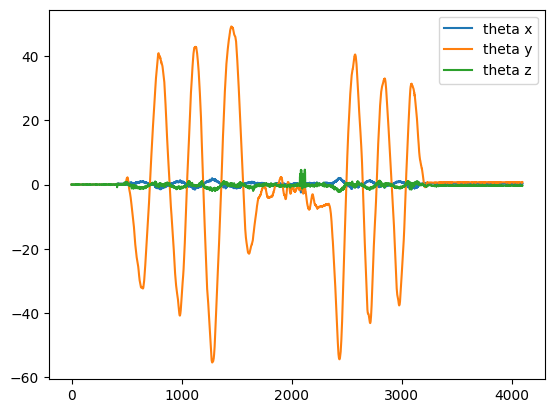

In [ ]:
plt.plot(_theta_x, label="theta x")
plt.plot(_theta_y, label="theta y")
plt.plot(_theta_z, label="theta z")
plt.legend()

In [ ]:
_del_r_0 = []
for i in tqdm(range(len(rmat))):
    _del_r_0.append(rmat[i].T@rmat[0])

# calculating angle for mc
_theta_x_0 = []
_theta_y_0 = []
_theta_z_0 = []

for i in tqdm(_del_r_0):
    _theta_x_0.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y_0.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z_0.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x_0 = np.array(_theta_x_0)
_theta_y_0 = np.array(_theta_y_0)
_theta_z_0 = np.array(_theta_z_0)

# converting them to degrees
_theta_x_0 = np.rad2deg(_theta_x_0)
_theta_y_0 = np.rad2deg(_theta_y_0)
_theta_z_0 = np.rad2deg(_theta_z_0)
    

100%|██████████| 408/408 [00:00<00:00, 413951.63it/s]


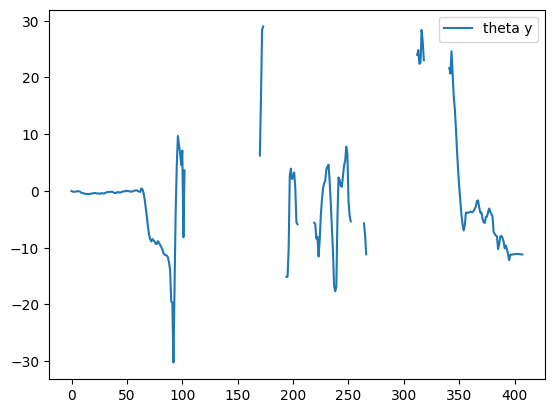

In [ ]:
# plt.plot(_theta_x_0, label="theta x")
plt.plot(_theta_y_0, label="theta y")
# plt.plot(_theta_z_0, label="theta z")
plt.legend()

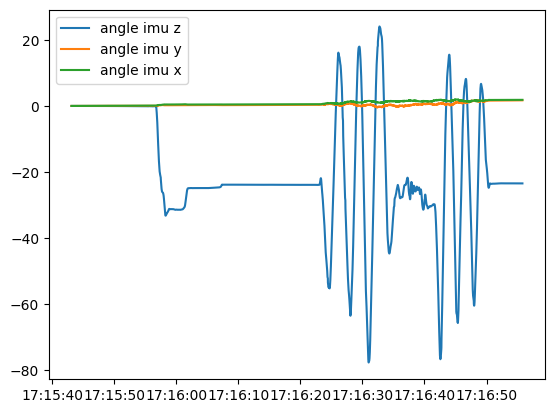

In [ ]:
plt.plot(_imu_df["time"],-_imu_df["ang_z"].to_numpy(), label =  "angle imu z")
plt.plot(_imu_df["time"],_imu_df["ang_y"].to_numpy(), label =  "angle imu y")
plt.plot(_imu_df["time"],_imu_df["ang_x"].to_numpy(), label =  "angle imu x")
# plt.plot(_mocap_df["time"], _theta_y, label = "angle mocap z")
plt.legend()

In [ ]:
timeoffset = 0.8
ar_df = ar_df.with_columns([pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).explode()])

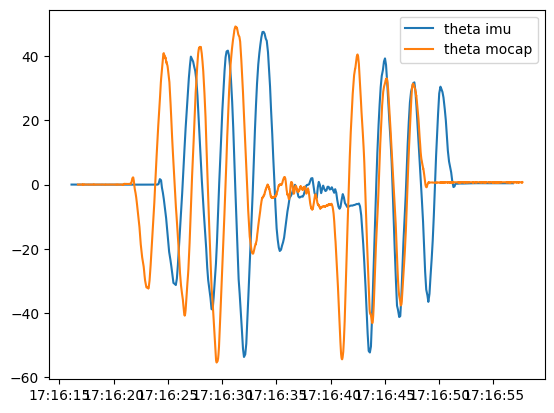

In [ ]:
_imu = _imu_df.clone()

_imu, ar_df = trunkate_dfs(_imu.to_pandas(), ar_df.to_pandas())
_imu = pl.from_pandas(_imu)
ar_df = pl.from_pandas(ar_df)

columns = ["ang_x", "ang_y", "ang_z", "ax", "ay", "az", "gx", "gy", "gz"]
_imu = pl.from_pandas(interpolate_target_df(_imu, ar_df, columns))

plt.plot(ar_df["time"] + timedelta(seconds = 1),-_imu["ang_z"] + _imu["ang_z"][0], label="theta imu")
plt.plot(_mc_df["time"],_theta_y, label="theta mocap")
plt.legend()

Basic operations interpolations etc

In [ ]:
_mdf = _mocap_df.copy()
_cdf = ar_df.to_pandas()
_cols = []
for i in ["x", "y", "z"]:
    _cols.append(_om[i])
    _cols.append(_xm[i])
    _cols.append(_zm[i])
_cdf["time"] = pd.to_datetime(_cdf["time"])
_mo_df = interpolate_target_df(_mdf, _cdf, _cols)
_mo_df = pl.from_pandas(_mo_df)

In [ ]:
_rinpmat = []
for i in tqdm(range(len(_mo_df))):
    
    _x_vec = _mo_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _mo_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _mo_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rinpmat.append(calculate_rotmat(_x_vec, _z_vec, _org))

100%|██████████| 408/408 [00:00<00:00, 3554.89it/s]


In [ ]:
_imurmat_x = []
_imurmat_y = []
_imurmat_z = []
_i_theta = 0

imu_df = _imu.clone()
for i in range(len(imu_df)):
    _i_theta = np.deg2rad(-imu_df["ang_z"][i] + imu_df["ang_z"][0])
    
    _imurmat_x.append(np.array([[1, 0, 0],
                                [0, np.cos(_i_theta), -np.sin(_i_theta)],
                                [0, np.sin(_i_theta), np.cos(_i_theta)]]))    
    
    _imurmat_y.append(np.array([[np.cos(_i_theta), 0, np.sin(_i_theta)],
                                [0, 1, 0],
                                [-np.sin(_i_theta), 0, np.cos(_i_theta)]]))
    
    _imurmat_z.append(np.array([[np.cos(_i_theta), -np.sin(_i_theta), 0],
                                [np.sin(_i_theta), np.cos(_i_theta), 0],
                                [0, 0, 1]]))

In [ ]:
print(len(ar_df), len(_theta_y_0))

408 408


In [ ]:
angle_skateboard = {"rx":[], "ry":[], "rz":[]}

_imu_dr = []
for i in range(len(ar_df)):
    
    _dr = orthormat[0].T @ _imurmat_y[i]   
    _dr = _dr.T 
    _imu_dr.append(_dr)
    tx = np.arctan2(_dr[2,1], _dr[2,2])
    ty = np.arctan2(-_dr[2,0], np.sqrt(_dr[2,1]**2 + _dr[2,2]**2))
    tz = np.arctan2(_dr[1,0], _dr[0,0])
    
    angle_skateboard["rx"].append(tx)
    angle_skateboard["ry"].append(ty)
    angle_skateboard["rz"].append(tz)

In [ ]:
_i_theta = np.deg2rad(45)
ar = np.array([[np.cos(_i_theta), 0, np.sin(_i_theta)],
                [0, 1, 0],
                [-np.sin(_i_theta), 0, np.cos(_i_theta)]])

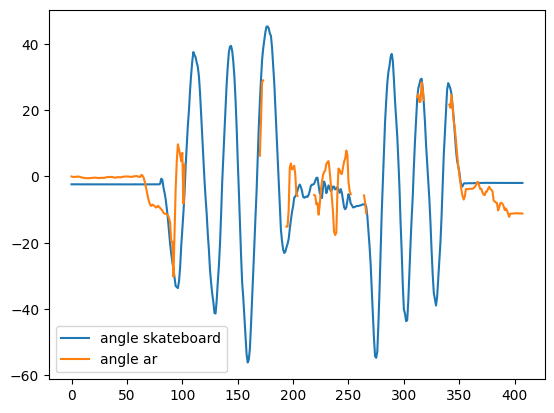

In [ ]:
plt.plot(np.rad2deg(angle_skateboard["ry"]), label = "angle skateboard")
plt.plot(_theta_y_0, label = "angle ar")
plt.legend()

Marker 0

In [ ]:
rA_m1 = np.array([0.02, 0., -0.12]).reshape(3, 1)
rA_m1_d = np.array([0., 0.02, -0.115]).reshape(3, 1)

In [ ]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)

newdata = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):

    val = ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    
    pa_c = (_imu_dr[i] @ rA_m1_d + val)
    
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org )
    
    val = pa_b

    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val - offset

    reval = (rotMat.T @ (rval - initial)).T[0]
    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

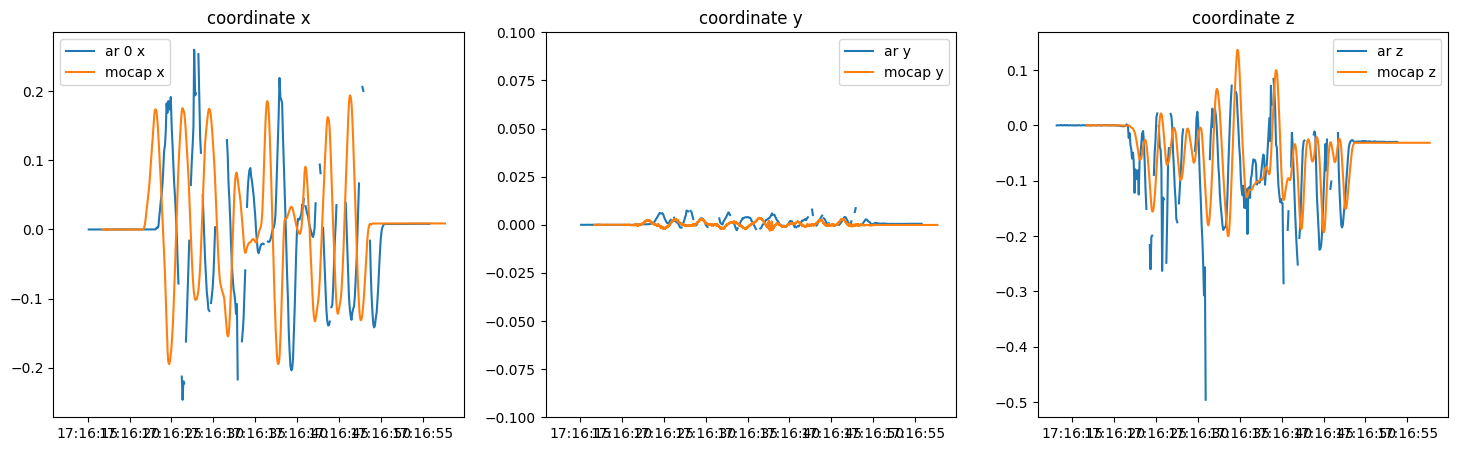

In [ ]:

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax1.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")


ax1.set_ylim(-0.1, 0.1)
ax1.set_title("coordinate y")
ax1.legend()

ax2.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax2.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax2.set_title("coordinate z")
# ax2.set_ylim(-0.3, 0.3) 

plt.legend()

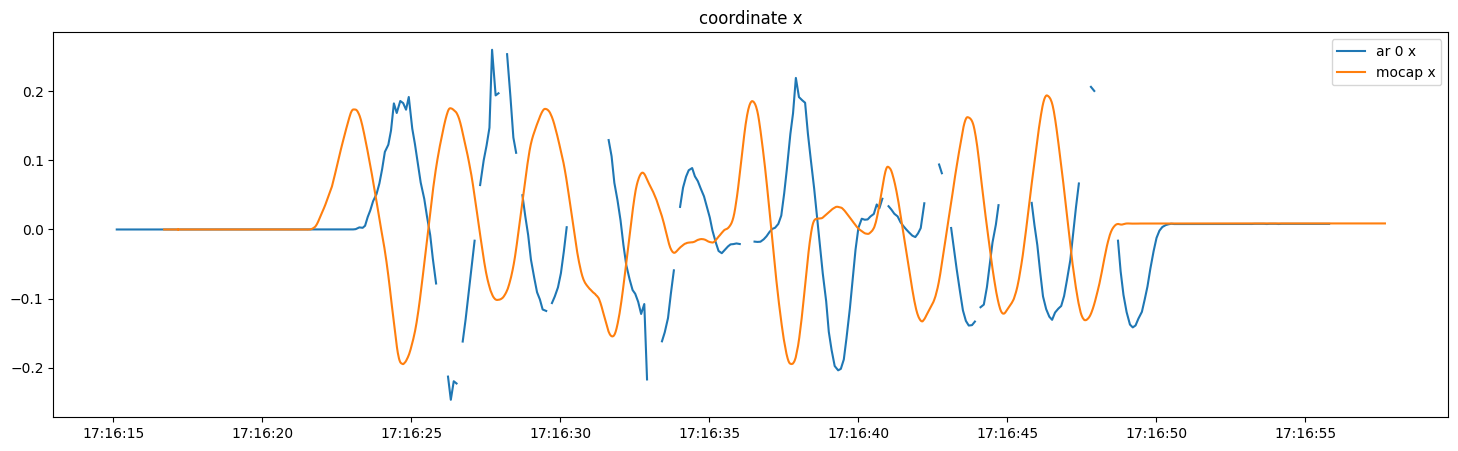

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

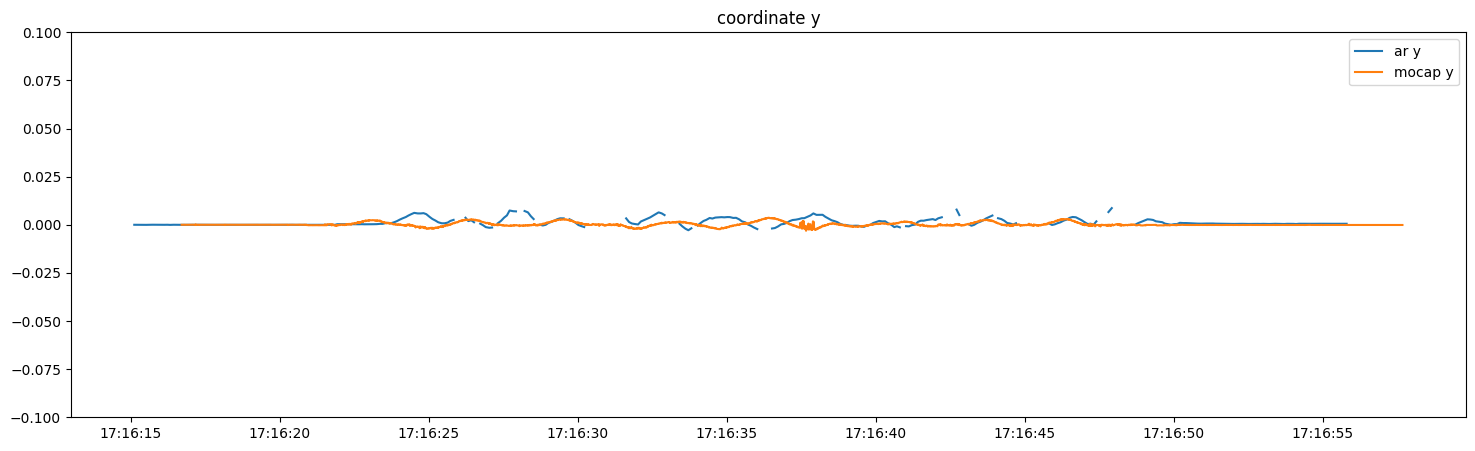

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax0.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")
ax0.set_ylim(-0.1, 0.1)
ax0.set_title("coordinate y")
ax0.legend()

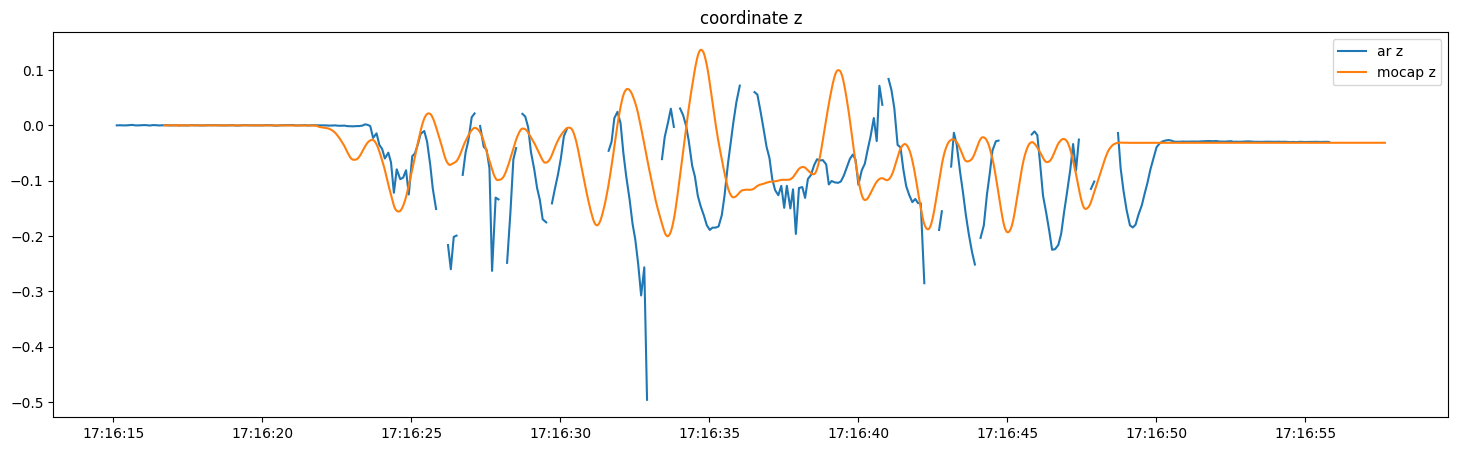

In [ ]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax0.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")
ax0.set_title("coordinate z")
ax0.legend()